# Solving the charge qubit in `QuTiP`

Again following one of the provided example notebooks, we'll walk through how to simulate the spectrum and dynamics of a charge/transmon qubit.

Hopefully the plots look a little nicer :)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from cycler import cycler
from qutip import Qobj, destroy, ket2dm, mesolve

%matplotlib inline

# set some plot defaults
mpl.rcParams['axes.grid'] = True
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# stole colors from scQubits
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#016E82",
        "#333795",
        "#2E5EAC",
        "#4498D3",
        "#CD85B9",
        "#45C3D1",
        "#AA1D3F",
        "#F47752",
        "#19B35A",
        "#EDE83B",
        "#ABD379",
        "#F9E6BE",
    ]
)

# Helper methods

## Hamiltonians

Define a `Qobj` based on the matrix form of the hamiltonian for a charge qubit:

$H = \sum\limits_n \left[ 4 E_C \left(n - n_g \right)^2 |n\rangle \langle n| - \frac{1}{2} E_J \left( |n\rangle \langle n+1| + |n+1\rangle \langle n| \right) \right] $

In [2]:
def hamiltonian(Ec, Ej, N, ng):
    """Return the charge qubit hamiltonian as a Qobj instance.
    
    Args:
        Ec (float): charging energy
        Ej (float): Josephson energy
        N (int): number of charge states
        ng (float): gate offset charge
    
    Returns:
        Qobj: the resulting hamiltonian as a Qobj
    """
    m = (
        np.diag(4 * Ec * (np.arange(-1 * N, N + 1) - ng) ** 2)
        + 0.5 * Ej * (np.diag(-1 * np.ones(2 * N), 1) + np.diag(-1 * np.ones(2 * N), -1))
    )
    return Qobj(m)

And the flux-tunable transmon in the phase basis:

$H = 4 E_C N^2 - E_{J1} \cos(\phi - \phi_\text{ext}) - E_{J2} \cos(\phi)$

In [3]:
def h_transmon_phase(flux_vec, phi_vec, Ec, Ej1, Ej2):
    """Return the transmon qubit hamiltonian in the phase basis as a Qobj instance.
    
    Args:
        flux_vec (Array): vector of external fluxes, in units of Phi_0
        phi_vec (Array): vector of phases
        Ec (float): charging energy
        Ej1 (float): Josephson energy of first JJ in SQUID
        Ej2 (float): Josephson energy of second JJ in SQUID

    Returns:
        Qobj: the resulting hamiltonian as a Qobj
    """
    phi = Qobj(np.diag(phi_vec))
    delta = phi_vec[1] - phi_vec[0]
    Nmax = len(phi_vec)
    Nsquared =  Qobj(
        (-1 / delta ** 2)
        * (np.diag(np.ones(Nmax - 1), 1) - 2 * np.diag(np.ones(Nmax)) + np.diag(np.ones(Nmax - 1), -1))
    )
    ham = (
        4 * Ec * Nsquared
        - Ej1 * Qobj(np.diag(np.cos(phi_vec - 2 * np.pi * flux_vec))) - Ej2 * Qobj(np.diag(np.cos(phi_vec)))
    )
    return ham

## Visualization

In [4]:
def plot_energies(ng_vec, energies, ymin=(-2, -0.1), ymax=(20, 20), charge=True):
    """Plot energy levels as a function of bias parameter ng_vec.
    
    Args:
        ng_vec (List[float]): vector of gate offset charge values
        energies (Array): eigenergies, dimension (len(ng_vec), 2*N + 1)
        ymin (Tuple(float)): min values for y-axis of subplots. Default (-2, -0.1)
        ymax (Tuple(float)): max values for y-axis of subplots. Default (20, 20)
        charge (bool): if the basis is charge (True) or phase (False). Default True
    
    Returns:
        fig, ax: matplotlib instances for plotting
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    for n in range(len(energies[0, :])):
        if n < 5:
            label = r'$E_{%d}$'%(n)
        else:
            label = None
        ax[0].plot(
            ng_vec,
            energies[:, n],
            label=label
        )

    ax[0].set_ylim(ymin[0], ymax[0])
    
    if charge:
        ax[0].set_xlabel(r'$n_g$', fontsize=18)
    else:
        ax[0].set_xlabel(r'$\Phi/\Phi_0$', fontsize=18)
    
    ax[0].set_ylabel(r'$E_n$ (GHz)', fontsize=18)
    ax[0].set_title('Energy eigenvalues', fontsize=18)
    ax[0].legend()

    for n in range(1,len(energies[0, :])):
        if n < 5:
            label = r'$E_{%d}-E_{0}$'%(n)
        else:
            label = None
        ax[1].plot(
            ng_vec,
            (energies[:, n] - energies[:, 0]),
            label=label
        )

    ax[1].set_ylim(ymin[1], ymax[1])

    if charge:
        ax[1].set_xlabel(r'$n_g$', fontsize=18)
    else:
        ax[1].set_xlabel(r'$\Phi/\Phi_0$', fontsize=18)

    ax[1].set_ylabel(r'$E_n-E_0$ (GHz)', fontsize=18)
    ax[1].set_title('Energy difference to the ground state', fontsize=18)
    ax[1].legend()
    return fig, ax

In [5]:
def visualize_dynamics(result, ylabel):
    """Plot the evolution of the expectation values stored in result.
    
    Args:
        result (result): the output of mesolve
        ylabe (str): label for y-axis of plot
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(
        result.times,
        result.expect[0],
    )
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(r"$t$", fontsize=18)

In [6]:
def plot_eigstates_charge(eig_vecs, N):
    """Plot energy eigenstates with respect to charge basis.
    
    Args:
        eig_vecs (Array): Eigenvectors returned by the eigenstates() method
        N (int): number of wavefunctions to plot
    
    Returns:
        fig, ax: matplotlib instances for plotting
    """
    fig, ax = plt.subplots(1, N, figsize=(16,6))
    for n in range(N):
        ax[n].plot(
            np.arange(len(eig_vecs)) - int(0.5 * len(eig_vecs)),
            np.real(eig_vecs[n].full()),
            'o-',
            markersize=10,
            label=r'$Re[\psi_{%d}]$'%(n)
        )
        ax[n].plot(
            np.arange(len(eig_vecs)) - int(0.5 * len(eig_vecs)),
            np.imag(eig_vecs[n].full()),
            '^--',
            markersize=10,
            label=r'$Im[\psi_{%d}]$'%(n)
        )
    
        ax[n].set_xlim(-5, 5)
        ax[n].set_xlabel(r'Cooper pair number basis $|N\rangle$', fontsize=18)
        ax[n].set_ylabel(r'Probability amplitude', fontsize=18)
        ax[n].set_title(r'$\psi_{%d}$'%(n), fontsize=18)
        ax[n].legend()

    plt.tight_layout()
    return fig, ax

In [7]:
def plot_eigstates_phase(phi_vec, eig_vecs, N):
    """Plot energy eigenstates with respect to phase basis.
    
    Args:
        phi_vec (Array): vector of phases over which to plot the wavefunctions
        eig_vecs (Array): Eigenvectors returned by the eigenstates() method
        N (int): number of wavefunctions to plot
    
    Returns:
        fig, ax: matplotlib instances for plotting
    """
    fig, ax = plt.subplots(1,N, figsize=(16,6))
    for n in range(N):
        ax[n].plot(
            phi_vec,
            np.real(eig_vecs[n].full()),
            'o-',
            markersize=10,
            label=r'$Re[\psi_{%d}]$'%(n)
        )
        ax[n].plot(
            phi_vec,
            np.imag(eig_vecs[n].full()),
            '^--',
            markersize=10,
            label=r'$Im[\psi_{%d}]$'%(n)
        )
    
        ax[n].set_xlabel(r'phase $\phi$', fontsize=18)
        ax[n].set_ylabel(r'Probability amplitude', fontsize=18)
        ax[n].set_title(r'$\psi_{%d}$'%(n), fontsize=18)
        ax[n].legend()
    plt.tight_layout()
    return fig, ax

# Charge qubit ($E_J \sim E_C$)

In [8]:
N = 10  # number of cooper pair number basis (|-N>, ... |N>)
Ec = 1.0  # charging energy [h * GHz]
Ej = 1.0  # Jospehson energy [h * GHz]
ng = 0

In [9]:
ng_vec = np.linspace(-2, 2, 400)

energies = np.array(
    [hamiltonian(Ec, Ej, N, ng).eigenenergies() for ng in ng_vec]
)

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Energy eigenvalues'}, xlabel='$n_g$', ylabel='$E_n$ (GHz)'>,
        <Axes: title={'center': 'Energy difference to the ground state'}, xlabel='$n_g$', ylabel='$E_n-E_0$ (GHz)'>],
       dtype=object))

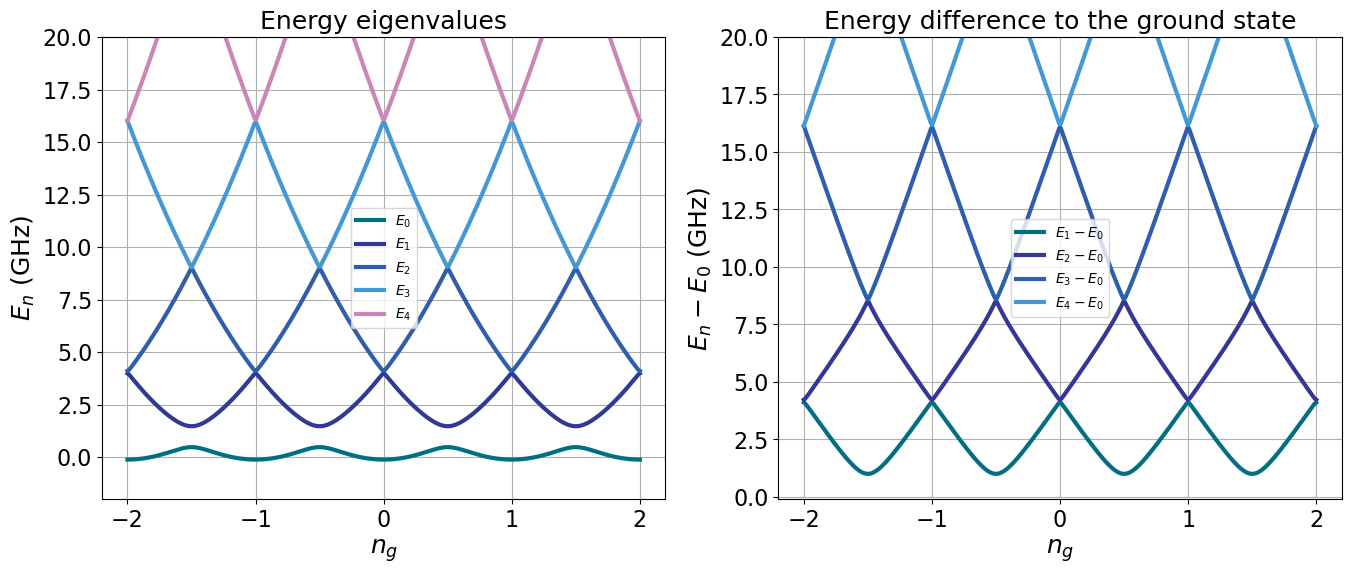

In [10]:
plot_energies(ng_vec, energies)

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: title={'center': '$\\psi_{0}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{1}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{2}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>],
       dtype=object))

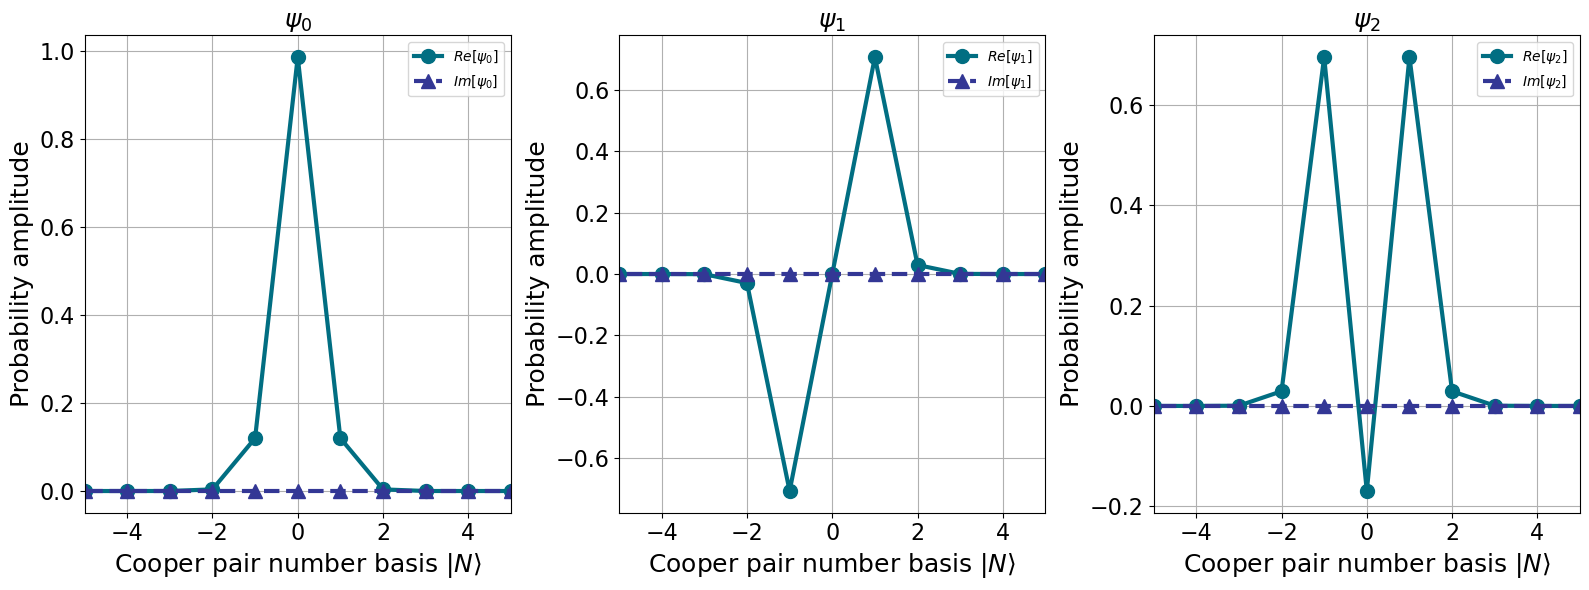

In [11]:
H = hamiltonian(Ec, Ej, N, ng=0)
evals, ekets = H.eigenstates()
plot_eigstates_charge(ekets, N=3)

# Transmon ($E_J/E_C \sim 50$)

## Charge basis

In [12]:
# parameters
N = 10 # number of charge basis (|-N>, ... |N>)
Ec = 0.2 # Charging energy [GHz]
Ej = 10.0 # Jospehson energy [GHz]
ng = 0

In [13]:
ng_vec = np.linspace(-2, 2, 400)

energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies() for ng in ng_vec])

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Energy eigenvalues'}, xlabel='$n_g$', ylabel='$E_n$ (GHz)'>,
        <Axes: title={'center': 'Energy difference to the ground state'}, xlabel='$n_g$', ylabel='$E_n-E_0$ (GHz)'>],
       dtype=object))

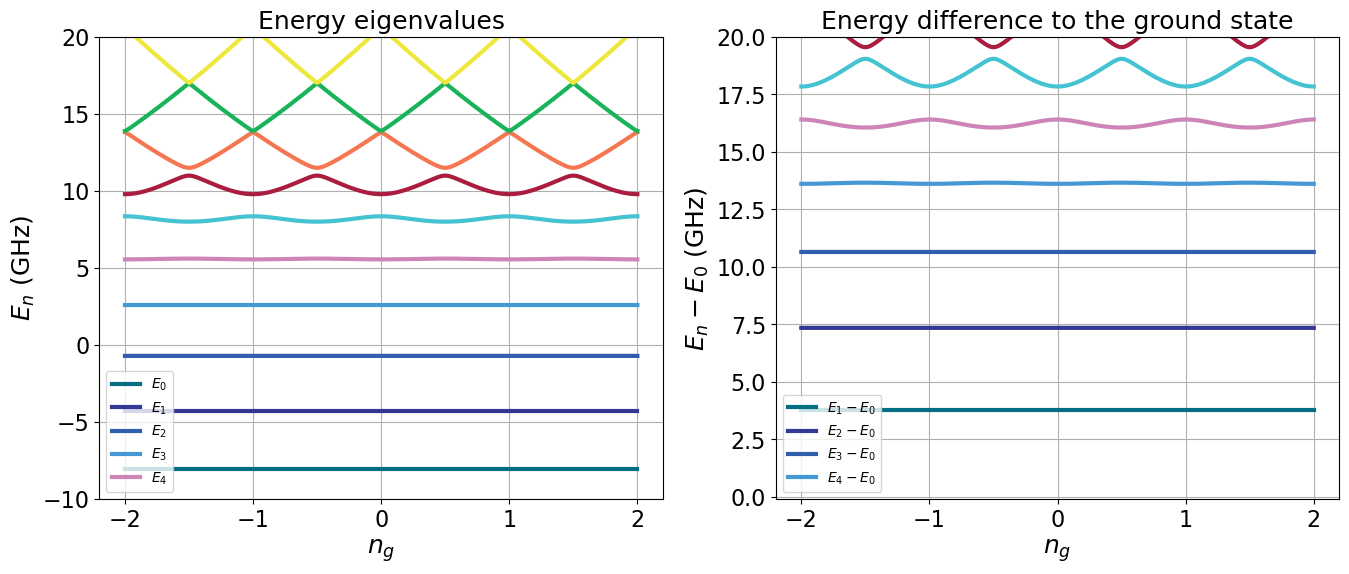

In [14]:
plot_energies(ng_vec, energies, ymin=(-10, -0.1))

What's the deal with those negative eigenvalues?

In [15]:
energies[0, 0]

np.float64(-8.05135590930381)

The solutions to the CPB hamiltonian are Mathieu equations, and the first eigenvalue is [[Koch2007]](https://arxiv.org/abs/cond-mat/0703002)

$E_0 (n_g) = E_C a_{2[n_g]}(-E_J /2 E_C)$,

where $a_{\nu}(q)$ is Mathieu’s characteristic value.

In [16]:
from scipy.special import mathieu_a

Ec * mathieu_a(2 * 0, -Ej / (2 * Ec))

np.float64(-8.051355909313358)

### Wavefunctions

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: title={'center': '$\\psi_{0}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{1}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{2}$'}, xlabel='Cooper pair number basis $|N\\rangle$', ylabel='Probability amplitude'>],
       dtype=object))

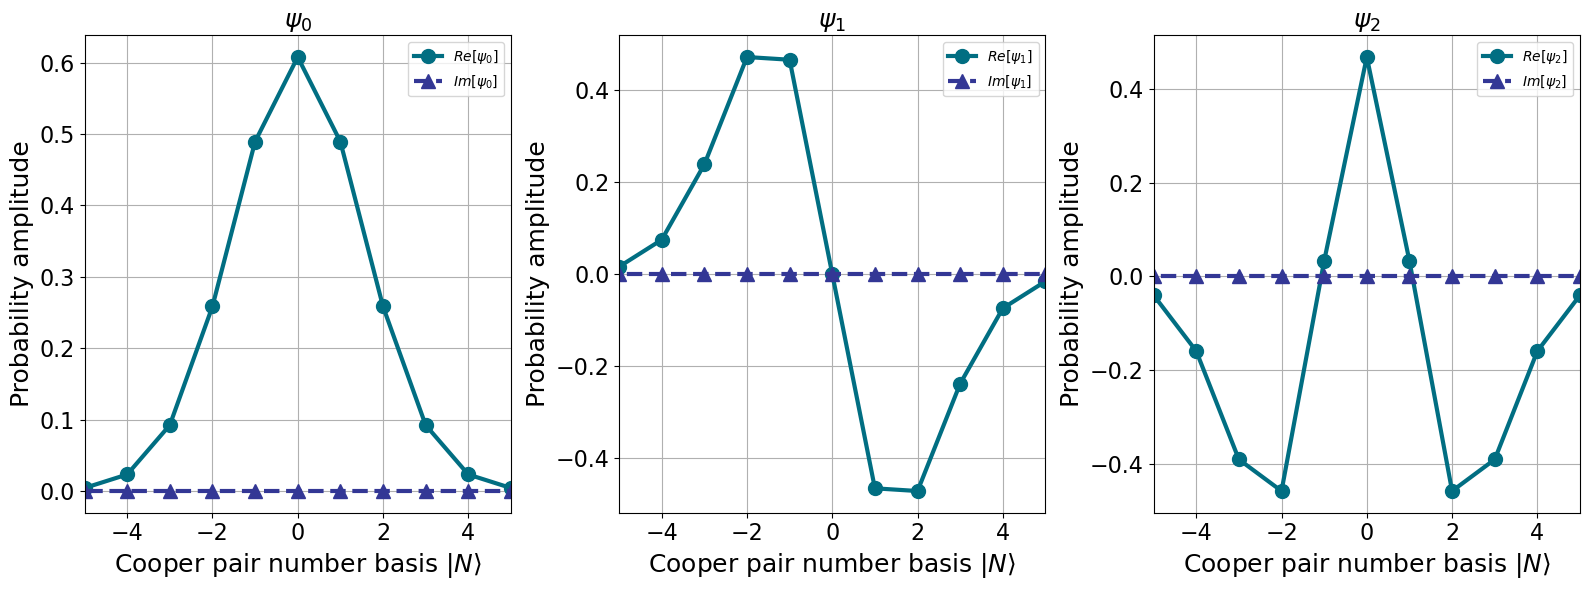

In [17]:
H = hamiltonian(Ec, Ej, N, ng=0)
evals, ekets = H.eigenstates()
plot_eigstates_charge(ekets, N=3)

## Phase basis

### Symmetric transmon $\left(E_{J1} = E_{J2}\right)$

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Energy eigenvalues'}, xlabel='$\\Phi/\\Phi_0$', ylabel='$E_n$ (GHz)'>,
        <Axes: title={'center': 'Energy difference to the ground state'}, xlabel='$\\Phi/\\Phi_0$', ylabel='$E_n-E_0$ (GHz)'>],
       dtype=object))

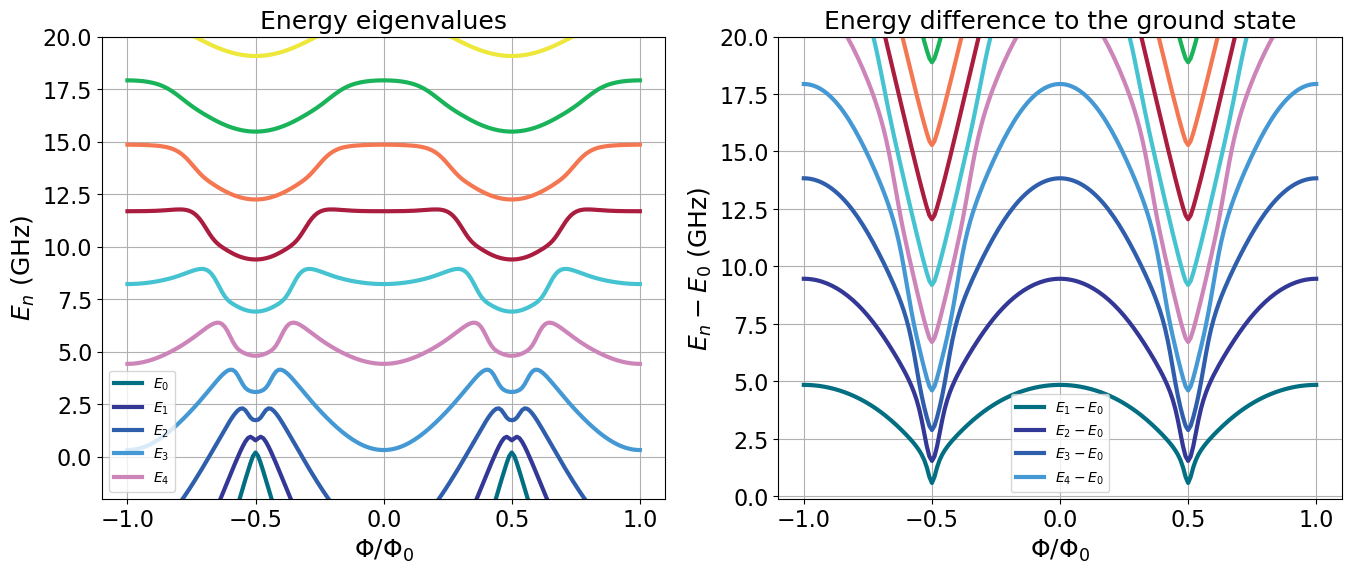

In [18]:
f_vec = np.linspace(-1, 1, 201)
phi_vec = np.linspace(-np.pi, np.pi, 101)

Ec = 0.2 # Charging energy [GHz]
Ej1 = 8.0 # Jospehson energy [GHz]
Ej2 = 8.0

eig_vals = []
for f in f_vec:
    eig_vals.append(h_transmon_phase(f, phi_vec, Ec, Ej1, Ej2).eigenenergies())
eig_vals = np.asarray(eig_vals)

plot_energies(f_vec, eig_vals, charge=False)

In the right plot, the spectrum becomes extremely sharp at half flux quanta. This is characteristic of symmetric transmons and is usually not a desirable feature. At those points, the qubit is no longer in the transmon regime, and the flux noise is extremely high.

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: title={'center': '$\\psi_{0}$'}, xlabel='phase $\\phi$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{1}$'}, xlabel='phase $\\phi$', ylabel='Probability amplitude'>,
        <Axes: title={'center': '$\\psi_{2}$'}, xlabel='phase $\\phi$', ylabel='Probability amplitude'>],
       dtype=object))

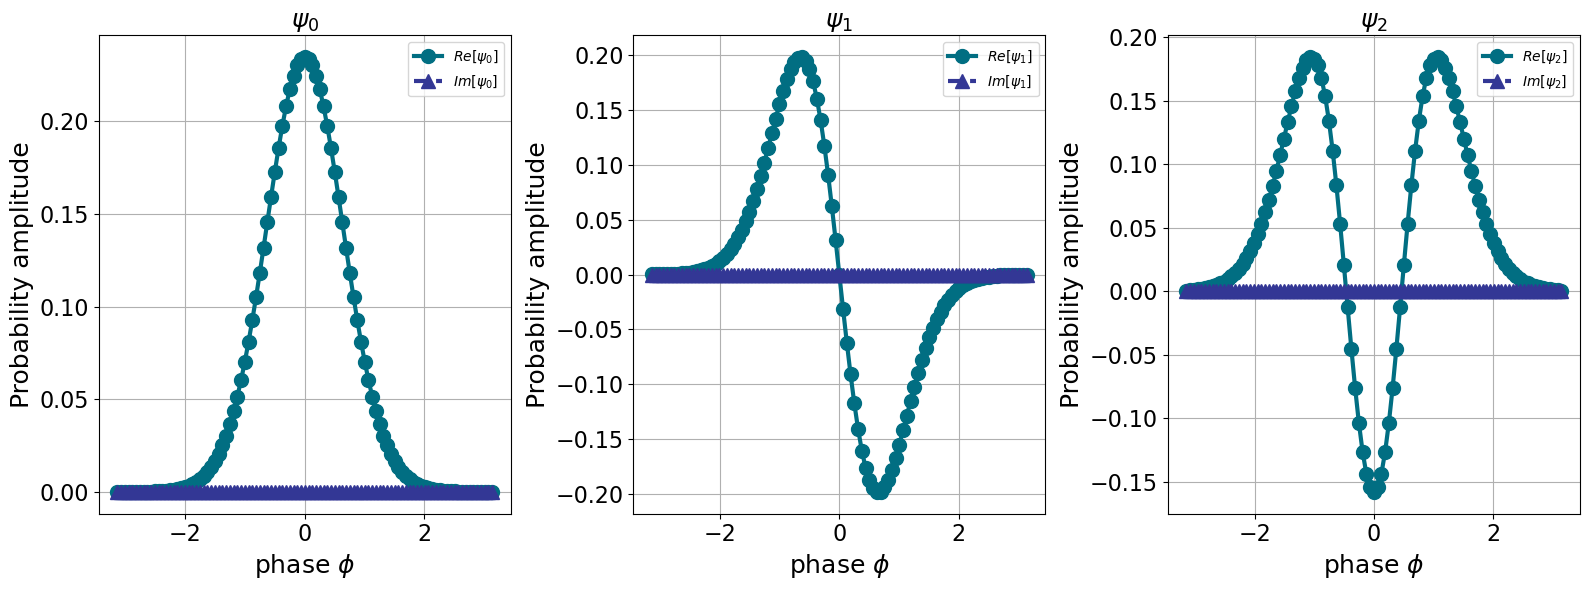

In [19]:
phi_vec = np.linspace(-np.pi, np.pi, 101)
Ec = 0.2 # Charging energy [GHz]
Ej1 = 5.0 # Jospehson energy [GHz]
Ej2 = 5.0

H = h_transmon_phase(0, phi_vec, Ec, Ej1, Ej2)
evals, ekets = H.eigenstates()
plot_eigstates_phase(phi_vec, ekets, N=3)

These may remind you of harmonic oscillator wavefunctions, and this is not a coincidence!

Remember the conjugate variable pairs. Phase and charge for our circuits, and position and momentum for your textbook HOs. The phase variable precisely serves the role of the position variable, and since the transmon is just a harmonic oscillator with a slightly anharmonic energy spectrum, the wavefunctions share a striking resemblance. 

### Asymmetric transmon $\left(E_{J1}\neq E_{J2}\right)$

By making the EJs of the two junctions very different, we realize an asymmetric transmon, also known as a weakly tunable transmon.

We sacrifice range in the frequency tuning range, but we can remain in the transmon regime at all or most values of flux, and the shallow slope throughout helps mitigate flux noise.

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Energy eigenvalues'}, xlabel='$\\Phi/\\Phi_0$', ylabel='$E_n$ (GHz)'>,
        <Axes: title={'center': 'Energy difference to the ground state'}, xlabel='$\\Phi/\\Phi_0$', ylabel='$E_n-E_0$ (GHz)'>],
       dtype=object))

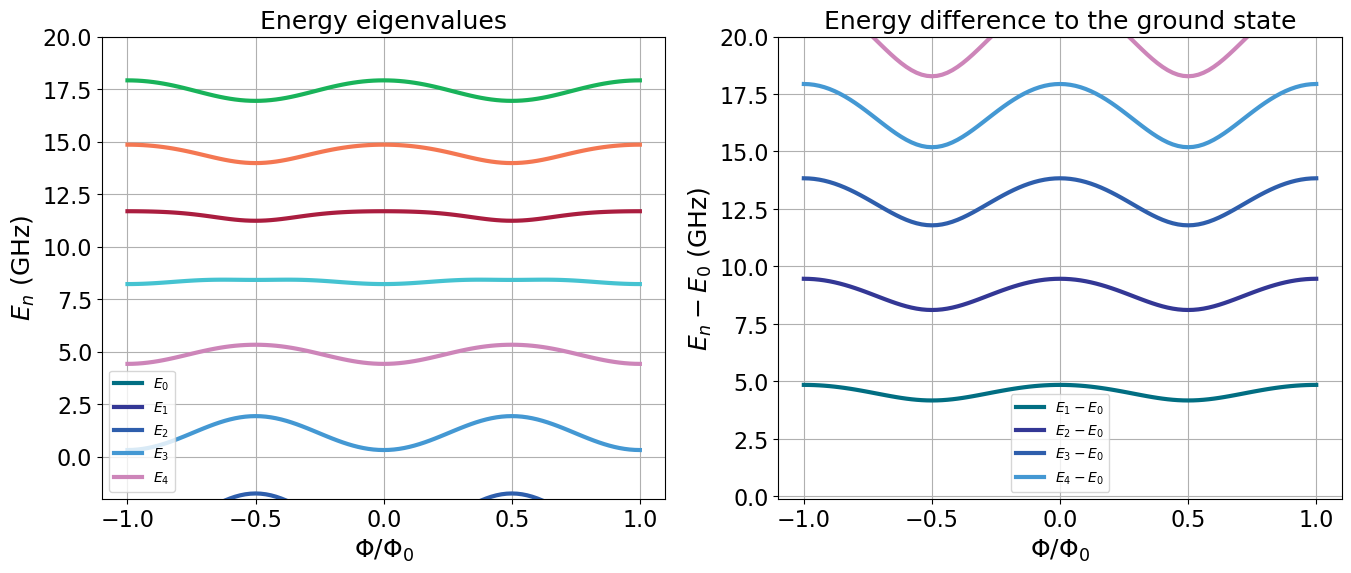

In [20]:
f_vec = np.linspace(-1, 1, 101)
phi_vec = np.linspace(-np.pi, np.pi, 101)

Ec = 0.2 # Charging energy [GHz]
Ej1 = 2.0 # Jospehson energy [GHz]
Ej2 = 14

eig_vals = []
for f in f_vec:
    eig_vals.append(h_transmon_phase(f, phi_vec, Ec, Ej1, Ej2).eigenenergies())
eig_vals = np.asarray(eig_vals)

plot_energies(f_vec, eig_vals, charge=False)

# Forming a qubit from lowest 2 levels

By operating in the CPB regime, we will make the qubit very anharmonic

In [21]:
N = 10
Ec = 1.0
Ej = 1.0

In [22]:
ng_vec = np.linspace(-1, 1, 200)

In [23]:
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies() for ng in ng_vec])

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Energy eigenvalues'}, xlabel='$n_g$', ylabel='$E_n$ (GHz)'>,
        <Axes: title={'center': 'Energy difference to the ground state'}, xlabel='$n_g$', ylabel='$E_n-E_0$ (GHz)'>],
       dtype=object))

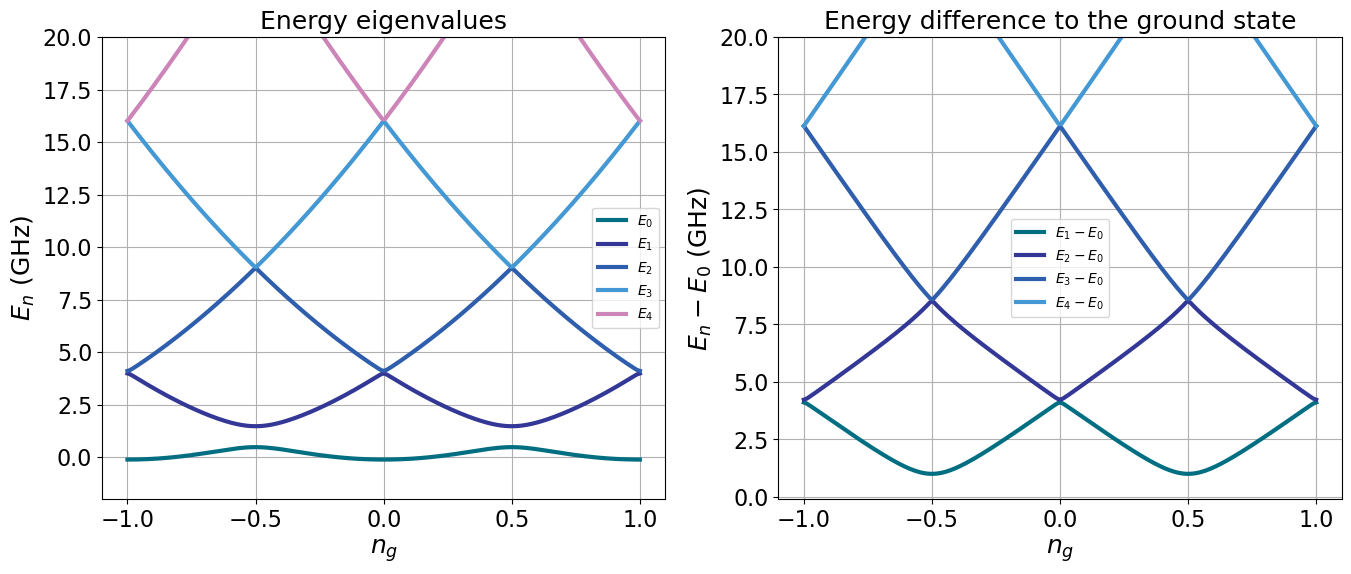

In [24]:
plot_energies(ng_vec, energies)

Zoom in around $n_g=0.5$

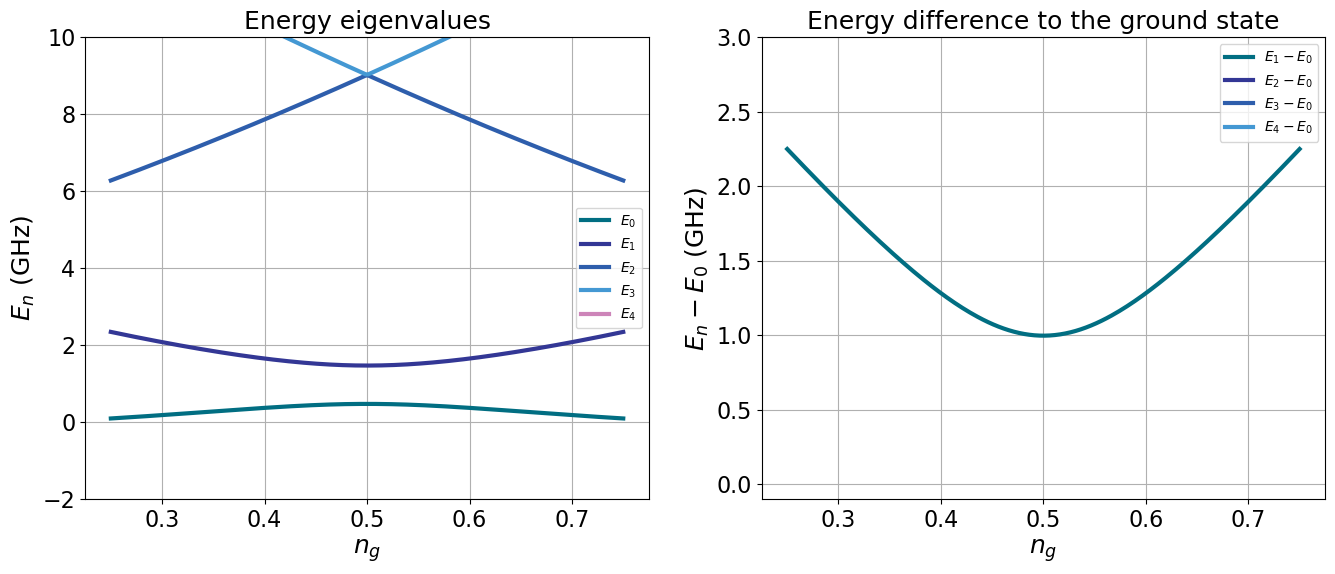

In [25]:
ng_vec = np.linspace(0.25, 0.75, 200)
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])
plot_energies(ng_vec, energies, ymax=(10, 3));

In [26]:
H = hamiltonian(Ec, Ej, N, 0.5)

H

Quantum object: dims=[[21], [21]], shape=(21, 21), type='oper', dtype=Dense, isherm=True
Qobj data =
[[441.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ -0.5 361.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.   -0.5 289.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.   -0.5 225.   -0.5   0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.   -0.5 169.   -0.5   0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.   -0.5 121.   -0.5   0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.   -0.5  81.   -0.5   0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    

In [27]:
evals, ekets = H.eigenstates()

evals

array([  0.47065435,   1.46676684,   9.01371984,   9.01760693,
        25.00520901,  25.00520943,  49.00260427,  49.00260427,
        81.00156252,  81.00156252, 121.00104167, 121.00104167,
       169.00074405, 169.00074405, 225.00055804, 225.00055804,
       289.00043403, 289.00043411, 361.00034728, 361.00347214,
       441.00312494])

Let's look at which states have significant weight in the two lowest eigenstates:

In [28]:
abs(ekets[0].full()) > 0.1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [29]:
abs(ekets[1].full()) > 0.1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

It's only two of them!

We can define a qubit basis with these two states:

In [30]:
psi_g = ekets[0]  # basis(2, 0)
psi_e = ekets[1]  # basis(2, 1)

In [31]:
sx = psi_g * psi_e.dag() + psi_e * psi_g.dag()
sz = psi_g * psi_g.dag() - psi_e * psi_e.dag()

## Sinusoidal drive on the qubit

As in the introductory notebook, we can drive the qubit with a $\sigma_x$ interaction:

$H = \frac{\Delta}{2}\sigma_z + A\sin (\omega t) \sigma_x$

In [32]:
H0 = 0.5 * (evals[1] - evals[0]) * sz

A = 0.1
Hd = 0.5 * A * sx

In [33]:
Heff = [H0, [Hd, "sin(wd*t)"]]  # string-format based -- many other formats possible, look at documentation!

args = {"wd": (evals[1] - evals[0])}  # drive resonantly on the ge transition

In [34]:
tlist = np.linspace(0.0, 50 / A, 1000)
result = mesolve(Heff, psi_g, tlist, [], [ket2dm(psi_g), ket2dm(psi_e)], args=args)

/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/core/coefficient.py:420: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


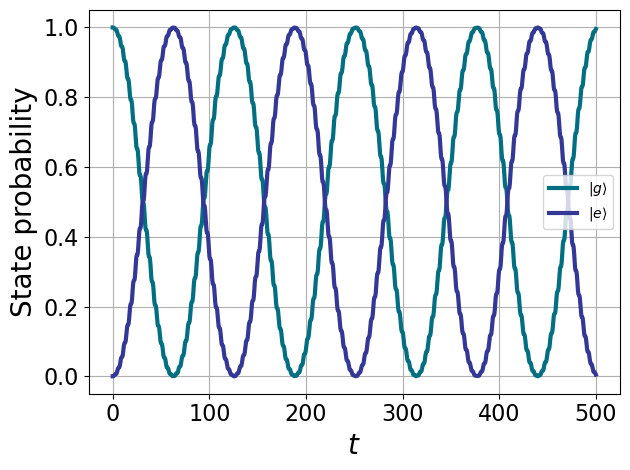

In [35]:
fig, ax = plt.subplots(1, 1)
labels = [r"$| g \rangle$", r"$| e \rangle$"]
for i, energies in enumerate(result.expect):
    ax.plot(
        tlist,
        energies,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("State probability", fontsize=20)
plt.tight_layout()

This calculation involved 21 states, but the majority don't contribute to the dynamics - can we simplify it?

### Eliminate states uninvolved with dynamics

In [36]:
keep_states = np.where(abs(ekets[1].full().flatten()) > 0.1)[0]

In [37]:
keep_states

array([10, 11])

In [38]:
H0_tls = Qobj(H0.full()[keep_states, :][:, keep_states])

H0_tls

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[2.40574436e-04 4.96105212e-01]
 [4.96105212e-01 2.40574436e-04]]

In [39]:
Hd_tls = Qobj(Hd.full()[keep_states, :][:, keep_states])

Hd_tls

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.98041296e-02 -4.16333634e-17]
 [-4.16333634e-17 -4.98041296e-02]]

In [40]:
Heff_tls = [H0_tls, [Hd_tls, "sin(wd*t)"]]

args = {"wd": (evals[1] - evals[0])}

In [41]:
psi_g_tls = Qobj(psi_g.full()[keep_states, :])
psi_e_tls = Qobj(psi_e.full()[keep_states, :])

In [42]:
tlist = np.linspace(0.0, 50 / A, 500)
result_tls = mesolve(Heff_tls, psi_g_tls, tlist, [], [ket2dm(psi_g_tls), ket2dm(psi_e_tls)], args=args)

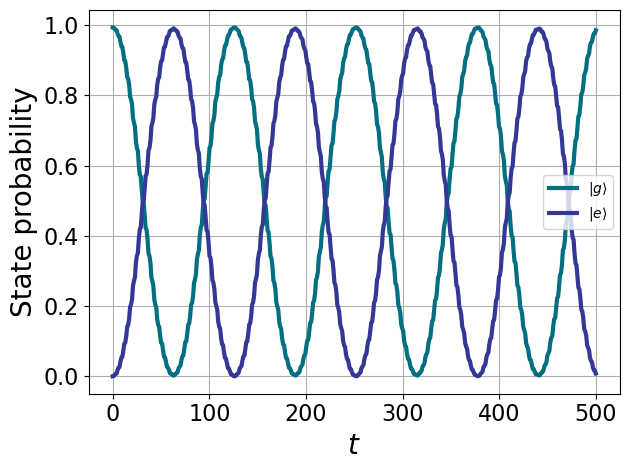

In [43]:
fig, ax = plt.subplots(1, 1)
labels = [r"$| g \rangle$", r"$| e \rangle$"]
for i, energies in enumerate(result_tls.expect):
    ax.plot(
        tlist,
        energies,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("State probability", fontsize=20)
plt.tight_layout()

# Quick comparison to the Duffing oscillator

Recall the Duffing oscillator, which is a perturbative approximation of the transmon hamiltonian near $n_g = 0$ [[Koch2007]](https://arxiv.org/abs/cond-mat/0703002):

$H_{\textrm{Duff}} = \sqrt{8 E_C E_J} (b + b^{\dagger}) - E_J - \frac{E_C}{12}(b + b^{\dagger})^4$

In [44]:
def h_duffing(Ec, Ej, N):
    """Return the Duffing oscillator hamiltonian as a Qobj instance.
    
    Args:
        Ec (float): charging energy
        Ej (float): Josephson energy
        N (int): number of fock states
    
    Returns:
        Qobj: the resulting hamiltonian as a Qobj
    """
    b = destroy(N)
    m = (
        np.sqrt(8 * Ec * Ej) * (b.dag() * b + 1/2) - Ej - Ec/12 * (b + b.dag()) ** 4
    )
    return Qobj(m)

Let's compare the accuracy of the first 10 eigenvalues:

In [45]:
Ec = 1
Ej = 50
N = 10

h_duff = h_duffing(Ec, Ej, N)

h_full = hamiltonian(Ec, Ej, N, 0)

In [46]:
(h_duff.eigenenergies() - h_full.eigenenergies()[:10]) / h_full.eigenenergies()[:10]

array([ 2.54257378e-04,  3.85347270e-03,  9.88545062e-02, -8.04262393e-02,
       -6.84073643e-02, -5.93499460e-02,  1.16550339e-01,  7.66080437e-02,
        4.35478102e-01,  2.79104149e-01])